What i have accomplished so far:

- Data cleaning and analysis: 
    - Winrate for champions, composition(both champions and roles), first objectives
    - Banrate analysis
    - Relevance for each objective
- Correlation analysis (incomplete)
- Data modeling using random forest: 
    - With every information: 97% accuracy and 
    - With only picks and first early objectives, simulating risk and gambling analysis (71%)

- To be done: Had the idea to analyse which heroes are more early game, mid game or late game 

# Step one: Data analysis and cleaning

In [87]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

In [88]:
# Reading the main data
df = pd.read_csv('games.csv')

print(f'Shape: {df.shape}')
df.columns

Shape: (51490, 61)


Index(['gameId', 'creationTime', 'gameDuration', 'seasonId', 'winner',
       'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald', 't1_champ1id', 't1_champ1_sum1',
       't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1', 't1_champ2_sum2',
       't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id',
       't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1',
       't1_champ5_sum2', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills',
       't1_dragonKills', 't1_riftHeraldKills', 't1_ban1', 't1_ban2', 't1_ban3',
       't1_ban4', 't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2',
       't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id',
       't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1',
       't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2',
       't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHer

In [89]:
# Reading the first champions json
import json
f = open('champion_info.json')
champs = json.load(f)
rows = []
champs_1_df = pd.DataFrame(columns=['id', 'name'])
for champion_id, champion_data in champs['data'].items():
    champ_id = int(champion_id)
    name = champion_data['name']
    rows.append({'id': champ_id, 'name': name})
    
champs_1_df['name'] = [row['name'] for row in rows]
champs_1_df['id'] = [row['id'] for row in rows]

f.close()
champs_1_df

,id,name
0,1,Annie
1,2,Olaf
2,3,Galio
3,4,Twisted Fate
4,5,Xin Zhao
...,...,...
133,429,Kalista
134,432,Bard
135,497,Rakan
136,498,Xayah


In [90]:
# The second json's structure is a little bit different, the id's are not on the first element
# of the tuple, instead, they are inside the second one

f = open('champion_info_2.json')
champs_2 = json.load(f)
rows = []
champs_df = pd.DataFrame(columns=['id', 'name'])
for _, champion_data in champs_2['data'].items():
    # There is one specific dirty data, where the id -1 and the rest is just filled with None
    if float(champion_data['id']) < 0:
        continue
    champ_id = int(champion_data['id'])
    name = champion_data['name']
    role = champion_data['tags']
    rows.append({'id': champ_id, 'name': name, 'role': role})
champs_df['name'] = [row['name'] for row in rows]
champs_df['id'] = [row['id'] for row in rows]
champs_df['role'] = [row['role'] for row in rows]
f.close()
champs_df.sort_values('id',inplace=True)
champs_df

,id,name,role
57,1,Annie,[Mage]
52,2,Olaf,"[Fighter, Tank]"
89,3,Galio,"[Tank, Mage]"
73,4,Twisted Fate,[Mage]
112,5,Xin Zhao,"[Fighter, Assassin]"
...,...,...,...
37,429,Kalista,[Marksman]
68,432,Bard,"[Support, Mage]"
43,497,Rakan,[Support]
5,498,Xayah,[Marksman]


In [91]:
# Note that there arent any null values since the data was previously cleaned by its author
df.isna().sum().unique()

array([0], dtype=int64)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.02 sec] [RSS: 8.67856e-07] [loc=1832.363 scale=512.013]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 1.38412e-05] [loc=190.000 scale=1642.363]
[distfit] >INFO> [pareto    ] [0.07 sec] [RSS: 1.38412e-05] [loc=-274877906754.000 scale=274877906944.000]
[distfit] >INFO> [dweibull  ] [0.82 sec] [RSS: 9.35604e-07] [loc=1829.405 scale=407.208]
[distfit] >INFO> [t         ] [2.58 sec] [RSS: 8.67863e-07] [loc=1832.365 scale=512.014]
[distfit] >INFO> [genextreme] [3.96 sec] [RSS: 2.35144e-05] [loc=4727.278 scale=7.358]
[distfit] >INFO> [gamma     ] [0.68 sec] [RSS: 9.08094e-07] [loc=-8623.595 scale=25.800]
[distfit] >INFO> [lognorm   ] [1.30 sec] [RSS: 2.51632e-05] [loc=190.000 scale=1.833]
[distfit] >INFO> [beta      ] [1.57 sec] [RSS: 8.83661e-07] [loc=-19294.421 scale=34592.195]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 1.22606e-05] [loc=190.000 scale=4538.000]
[distfit] >INFO> [loggamma  ] [0.33 sec] [RSS

(<Figure size 2000x1500 with 1 Axes>,
 <AxesSubplot:title={'center':'\nnorm(loc=1832.36, scale=512.013)'}, xlabel='Values', ylabel='Frequency'>)

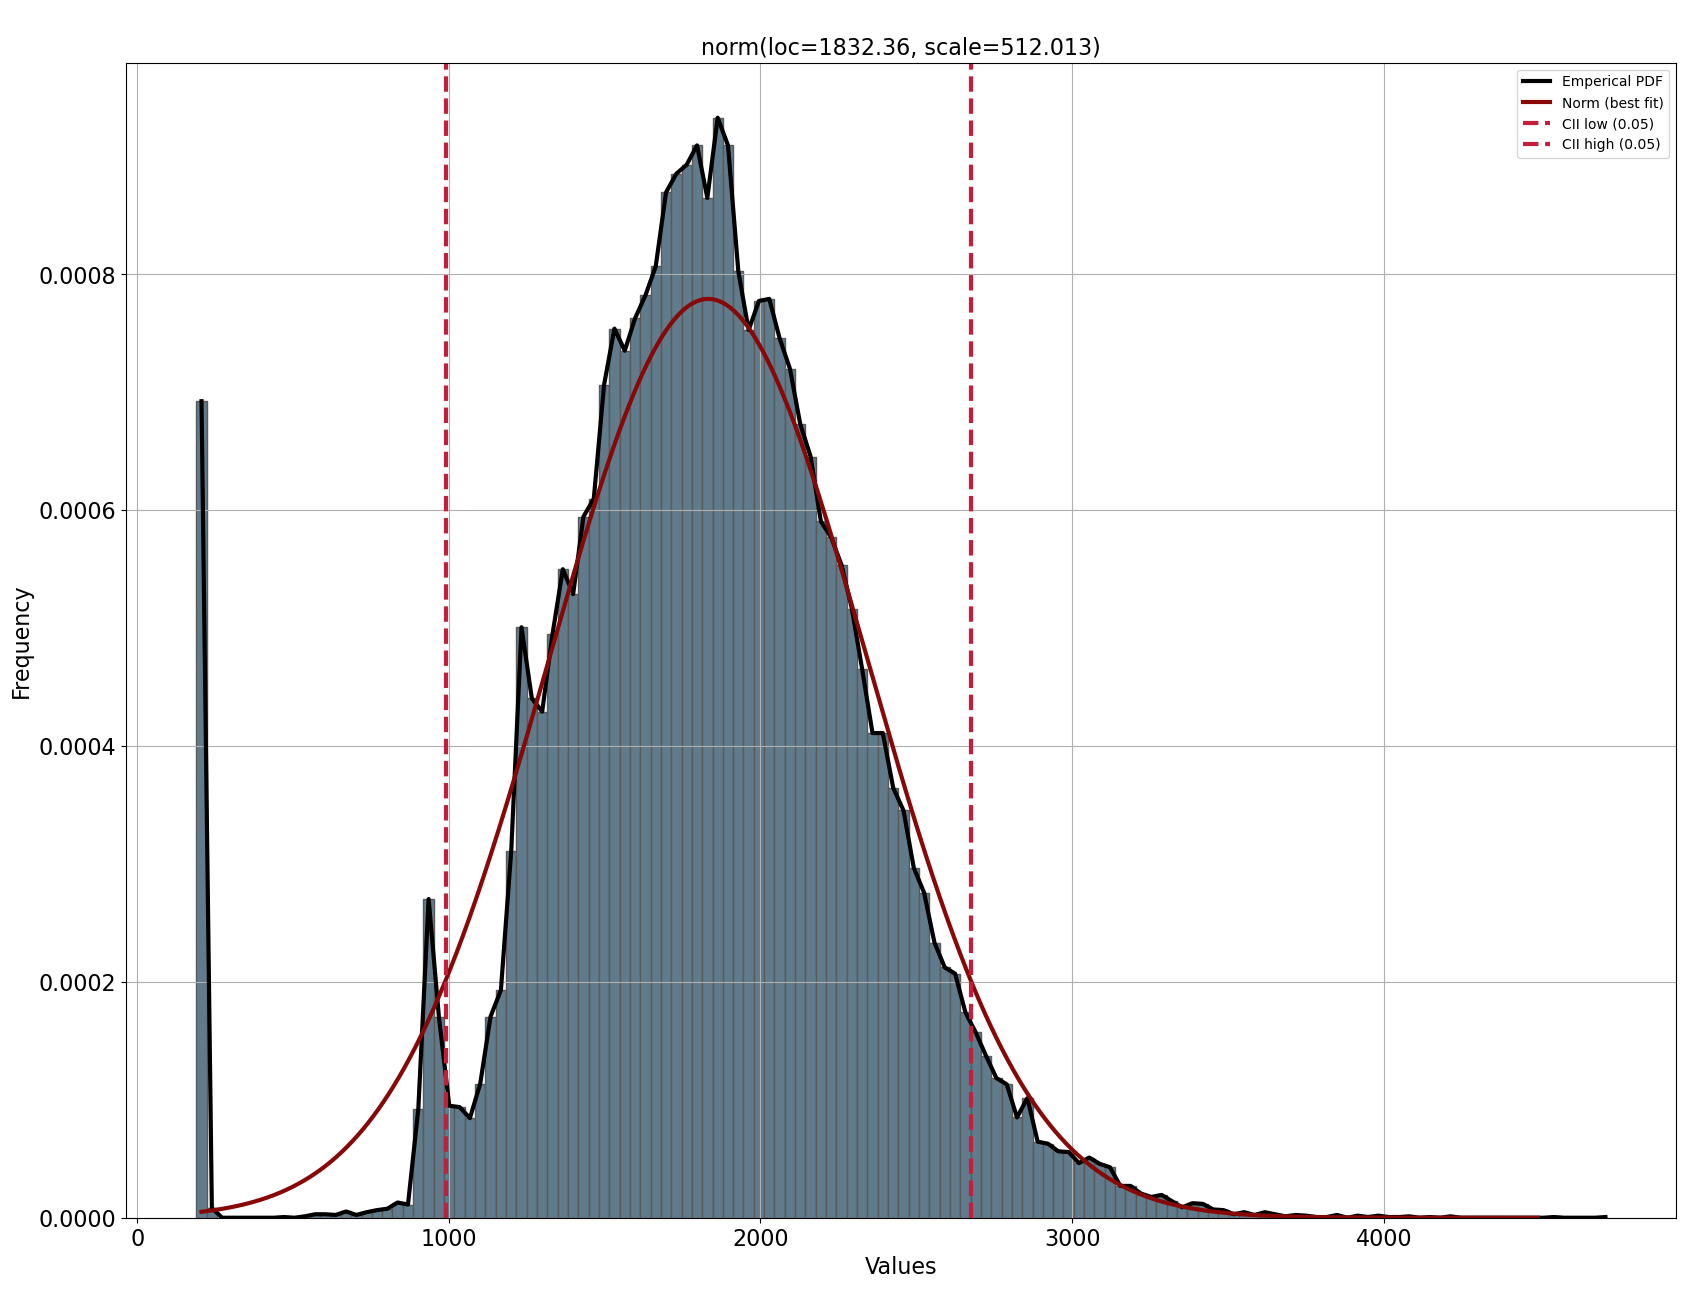

In [92]:
# Distribution
from distfit import distfit


dfit = distfit(todf=True)
results = dfit.fit_transform(df['gameDuration'])

dfit.plot()

Note that remaked matches are included in this dataframe, so i will remove them. I will remove the match periods from 3 to 15 minutes. Above that ff is possible and actual wins are unlikely. There may be some low-time ff due to disconnect but, in my interpretation, removing them is reasonable

In [93]:
remake = df[df['gameDuration'] <= 300].shape[0]
between_remake_and_surrender = df[((df['gameDuration'] > 300) & (df['gameDuration']<900))].shape[0]

print("remake: ", remake,"  between remake and surrender: ", between_remake_and_surrender)

remake:  1195   between remake and surrender:  114


In [94]:
# Removing potential remake matches
df = df[~((df['gameDuration'] < 900) & (df['gameDuration']>0))]
df_model = df.copy()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 2.50123e-07] [loc=1873.638 scale=448.629]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 9.88751e-06] [loc=901.000 scale=972.638]
[distfit] >INFO> [pareto    ] [0.11 sec] [RSS: 9.88751e-06] [loc=-137438952571.000 scale=137438953472.000]
[distfit] >INFO> [dweibull  ] [1.17 sec] [RSS: 7.53606e-07] [loc=1857.378 scale=380.519]
[distfit] >INFO> [t         ] [2.87 sec] [RSS: 2.50131e-07] [loc=1873.640 scale=448.629]
[distfit] >INFO> [genextreme] [2.13 sec] [RSS: 3.70552e-05] [loc=902.920 scale=8.774]
[distfit] >INFO> [gamma     ] [0.30 sec] [RSS: 1.42055e-07] [loc=-158.783 scale=99.201]
[distfit] >INFO> [lognorm   ] [2.11 sec] [RSS: 1.41342e-07] [loc=-1169.975 scale=3011.042]
[distfit] >INFO> [beta      ] [1.10 sec] [RSS: 1.42152e-07] [loc=-157.000 scale=557267672.014]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 1.17631e-05] [loc=901.000 scale=3827.000]
[distfit] >INFO> [loggamma  ] [0.68 sec] 

(<Figure size 2000x1500 with 1 Axes>,
 <AxesSubplot:title={'center':'\nlognorm(s=0.14672, loc=-1169.98, scale=3011.04)'}, xlabel='Values', ylabel='Frequency'>)

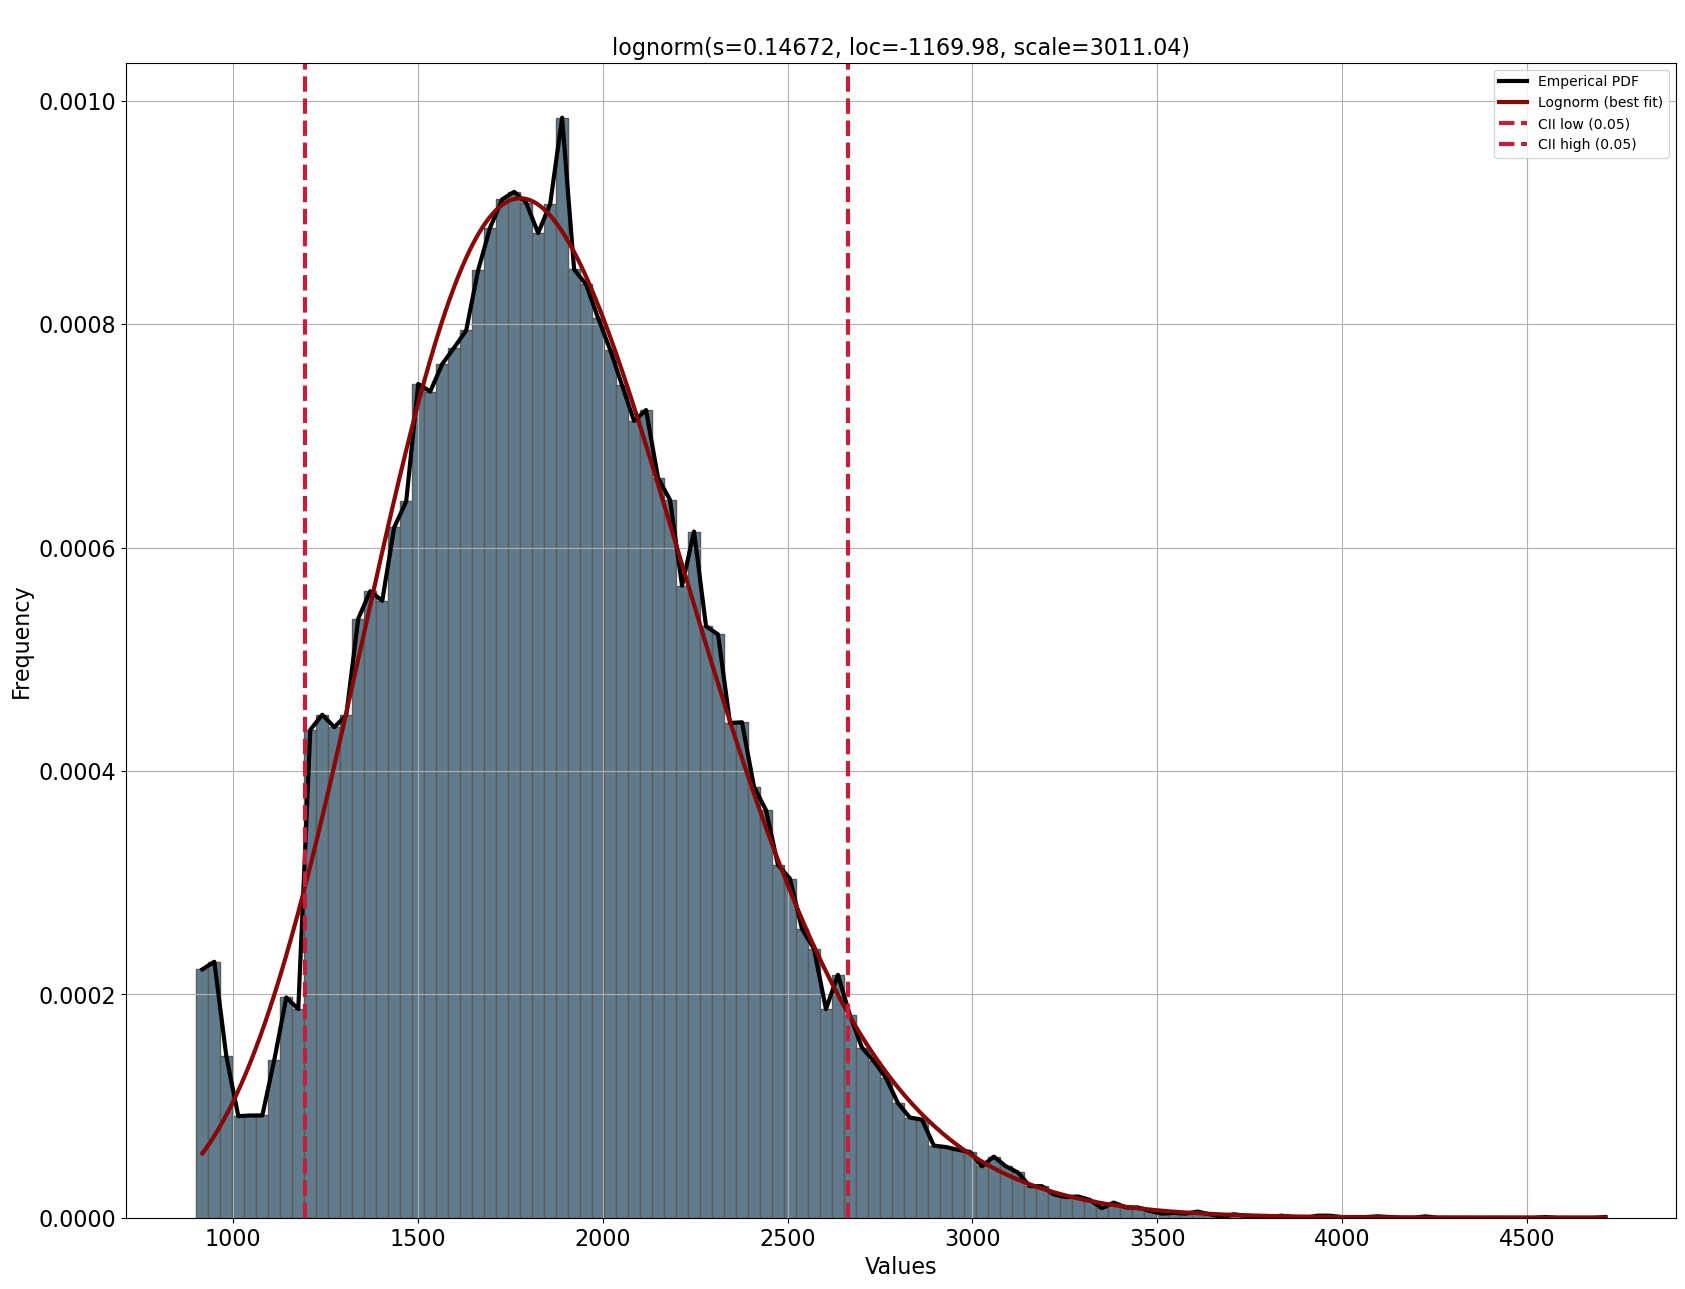

In [95]:
# Ploting distribution again
from distfit import distfit


dfit = distfit(todf=True)
results = dfit.fit_transform(df['gameDuration'])
dfit.plot()


### Analyzing champions' win percentage and pick/ban rate

In [96]:
# Analyzing champions' win percentage and pick/ban rate

champs_t1, champs_t2, bans_t1, bans_t2 = [],[],[],[]

# Getting columns that contains champions' appearances 'automatically'

# When testing, checking whether its alread in champ_t1 became necessary since compyling it twice
# would duplicate the list's values
for column in df.columns:
    if 'id' in column:
        if 't1' in column and column not in champs_t1:
            champs_t1.append(column)
        elif 't2' in column and column not in champs_t2:
            champs_t2.append(column)
    if 'ban' in column:
        if 't1' in column and column not in bans_t1:
            bans_t1.append(column)
        elif 't2' in column and column not in bans_t2:
            bans_t2.append(column)

In [97]:
# Extracting picked/banned percentage and getting the relevance:
# how many times a champion is picked when its not banned
# (number of picks) / ((total games) - (number of bans))
# In my opinion, this number would infer the best bans

df['picks'] = df[champs_t1 + champs_t2].values.tolist()
df['bans'] = df[bans_t1 + bans_t2].values.tolist()

df['comp'] = df[champs_t1 + champs_t2].values.tolist()

# I struggled a lot to assign lists/arrays to specific cells, so here's the solution i came up with
df['win/lose'] = np.where(df['winner'] == 1, '[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]', '[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]')
df['win/lose'] = df['win/lose'].apply(ast.literal_eval)
df_exploded = df.explode(['picks','bans','win/lose'])

pick_id = df_exploded['picks'].value_counts().reset_index()
ban_id = df_exploded['bans'].value_counts().reset_index()
winrate_id = df_exploded[['picks','win/lose']].groupby('picks').sum().reset_index()
winrate_id.rename(columns={'picks': 'index'},inplace=True)


# Since pd.merge only works for 2 dfs, had to do a step inside it
df_champion_stats = pd.merge(pick_id,pd.merge(ban_id,winrate_id,on='index'),on='index')
df_champion_stats['picked or banned (%)'] = (df_champion_stats['picks'] + df_champion_stats['bans'])*100/df.shape[0]
df_champion_stats['relevance (%)'] = df_champion_stats['picks']/(df.shape[0]-df_champion_stats['bans'])*100

df_exploded['picks'].value_counts().reset_index()

df_champion_stats.rename(columns={'index': 'id'}, inplace= True)
df_champion_stats = pd.merge(champs_df,df_champion_stats,on='id')

df_champion_stats[['picked or banned (%)', 'relevance (%)']] = df_champion_stats[['picked or banned (%)', 'relevance (%)']].round(2)
df_champion_stats.sort_values(by='relevance (%)', ascending = False)
df_champion_stats['winrate (%)'] = round(100*df_champion_stats['win/lose']/df_champion_stats['picks'],2)

df_champion_stats = df_champion_stats.sort_values('winrate (%)', ascending=False)

df_champion_stats

,id,name,role,picks,bans,win/lose,picked or banned (%),relevance (%),winrate (%)
39,40,Janna,"[Support, Mage]",8467,20921,4711,58.56,28.94,55.64
36,37,Sona,"[Support, Mage]",5298,595,2880,11.74,10.68,54.36
73,83,Yorick,"[Fighter, Tank]",1337,496,723,3.65,2.69,54.08
32,33,Rammus,"[Tank, Fighter]",2930,1798,1578,9.42,6.06,53.86
33,34,Anivia,"[Mage, Support]",2192,857,1177,6.08,4.44,53.70
...,...,...,...,...,...,...,...,...,...
68,78,Poppy,"[Tank, Fighter]",1840,155,832,3.98,3.68,45.22
42,43,Karma,"[Mage, Support]",3045,211,1372,6.49,6.09,45.06
128,268,Azir,"[Mage, Marksman]",1241,403,539,3.28,2.49,43.43
12,13,Ryze,"[Mage, Fighter]",1009,95,410,2.20,2.01,40.63


In [98]:
# Question: what team composition (i will be based only on roles, since champions would be more specific)
# has the highest winrate?
df['comp_1'] = df['picks'].apply(lambda x: x[:5])
df['comp_2'] = df['picks'].apply(lambda x: x[5:])


df[['winner','comp_1','comp_2']]

,winner,comp_1,comp_2
0,1,"[8, 432, 96, 11, 112]","[104, 498, 122, 238, 412]"
1,1,"[119, 39, 76, 10, 35]","[54, 25, 120, 157, 92]"
2,1,"[18, 141, 267, 68, 38]","[69, 412, 126, 24, 22]"
3,1,"[57, 63, 29, 61, 36]","[90, 19, 412, 92, 22]"
4,1,"[19, 29, 40, 119, 134]","[37, 59, 141, 38, 51]"
...,...,...,...
51485,2,"[19, 429, 91, 432, 64]","[45, 83, 67, 40, 79]"
51486,2,"[90, 32, 31, 412, 18]","[102, 429, 89, 75, 45]"
51487,2,"[141, 18, 432, 81, 68]","[1, 119, 33, 43, 99]"
51488,2,"[121, 236, 420, 201, 99]","[21, 56, 25, 30, 11]"


In [99]:
# Since trying to merge array with a dataframe is very tough, i will try it in another way:
# exploding it, merging and then making a list again

df_comps = df[['gameId','winner','comp_1','comp_2']]
df_comps = df_comps.explode(['comp_1','comp_2'])

df_comps = pd.merge(df_comps,champs_df.rename(columns={'id': 'comp_1','name':'name_1','role':'role_1'}), on='comp_1', sort=False)


df_comps = pd.merge(df_comps,champs_df.rename(columns={'id': 'comp_2','name':'name_2','role':'role_2'}), on='comp_2', sort=False)

df_comps = df_comps.sort_values('gameId')

# Here comes the tricky part: getting the team comps for each gameId
df_comps = df_comps.groupby('gameId').agg(
    {'comp_1': list, 
     'comp_2': list,
     'name_1': list,
     'name_2': list,
     'role_1': lambda x: [x.tolist()], 
     'role_2': lambda x: [x.tolist()], 
     'winner': 'first'
    }
).reset_index()

df_comps
# Note that the array is nested, so we have to undo it, for that i found a solution online

def unnest_array(array):
    # Unnest values and sort the role order
    # The reason i sorted is to prevent future errors of same composition with different orders
    unnested_array = sorted([item for sublist in array for sublist_2 in sublist for item in sublist_2], key=lambda x: x.lower())
    # Remove duplicates and return as sorted list
    return sorted(list(set(unnested_array)), key=lambda x: x.lower())

df_comps['role_1'] = df_comps['role_1'].apply(unnest_array)
df_comps['role_2'] = df_comps['role_2'].apply(unnest_array)


# Sorting names since pick order doesnt matter:

df_comps['name_1'] = df_comps['name_1'].apply(sorted)
df_comps['name_2'] = df_comps['name_2'].apply(sorted)


In [100]:
df_comps

,gameId,comp_1,comp_2,name_1,name_2,role_1,role_2,winner
0,3214824413,"[114, 40, 22, 11, 1]","[427, 412, 17, 245, 202]","[Annie, Ashe, Fiora, Janna, Master Yi]","[Ekko, Ivern, Jhin, Teemo, Thresh]","[Assassin, Fighter, Mage, Marksman, Support]","[Assassin, Fighter, Mage, Marksman, Support]",2
1,3214825708,"[266, 110, 121, 432, 131]","[103, 412, 58, 64, 29]","[Aatrox, Bard, Diana, Kha'Zix, Varus]","[Ahri, Lee Sin, Renekton, Thresh, Twitch]","[Assassin, Fighter, Mage, Marksman, Support, T...","[Assassin, Fighter, Mage, Marksman, Support, T...",1
2,3214843995,"[412, 41, 61, 64, 51]","[429, 54, 432, 104, 126]","[Caitlyn, Gangplank, Lee Sin, Orianna, Thresh]","[Bard, Graves, Jayce, Kalista, Malphite]","[Assassin, Fighter, Mage, Marksman, Support]","[Fighter, Mage, Marksman, Support, Tank]",1
3,3214844763,"[119, 35, 25, 14, 69]","[58, 236, 112, 412, 20]","[Cassiopeia, Draven, Morgana, Shaco, Sion]","[Lucian, Nunu, Renekton, Thresh, Viktor]","[Assassin, Fighter, Mage, Marksman, Support, T...","[Fighter, Mage, Marksman, Support, Tank]",1
4,3214845925,"[266, 40, 67, 105, 427]","[16, 34, 240, 161, 20]","[Aatrox, Fizz, Ivern, Janna, Vayne]","[Anivia, Kled, Nunu, Soraka, Vel'Koz]","[Assassin, Fighter, Mage, Marksman, Support, T...","[Fighter, Mage, Support, Tank]",2
...,...,...,...,...,...,...,...,...
49747,3331810857,"[43, 28, 103, 236, 31]","[19, 22, 238, 89, 57]","[Ahri, Cho'Gath, Evelynn, Karma, Lucian]","[Ashe, Leona, Maokai, Warwick, Zed]","[Assassin, Mage, Marksman, Support, Tank]","[Assassin, Fighter, Mage, Marksman, Support, T...",1
49748,3331821516,"[121, 29, 117, 57, 61]","[18, 201, 141, 63, 131]","[Kha'Zix, Lulu, Maokai, Orianna, Twitch]","[Brand, Braum, Diana, Kayn, Tristana]","[Assassin, Fighter, Mage, Marksman, Support, T...","[Assassin, Fighter, Mage, Marksman, Support, T...",2
49749,3331828122,"[150, 60, 41, 44, 429]","[79, 202, 99, 163, 23]","[Elise, Gangplank, Gnar, Kalista, Taric]","[Gragas, Jhin, Lux, Taliyah, Tryndamere]","[Fighter, Mage, Marksman, Support, Tank]","[Assassin, Fighter, Mage, Marksman, Support]",1
49750,3331830734,"[75, 498, 25, 157, 60]","[122, 102, 96, 67, 12]","[Elise, Morgana, Nasus, Xayah, Yasuo]","[Alistar, Darius, Kog'Maw, Shyvana, Vayne]","[Assassin, Fighter, Mage, Marksman, Support, T...","[Assassin, Fighter, Mage, Marksman, Support, T...",2


In [101]:
# Get most picked roles:
df_comps['role_1'] = df_comps['role_1'].astype(str)
df_comps['role_2'] = df_comps['role_2'].astype(str)
pd.concat([df_comps['role_1'],df_comps['role_2']]).value_counts()
df_comps[df_comps['role_1'] == df_comps['role_2']]

,gameId,comp_1,comp_2,name_1,name_2,role_1,role_2,winner
0,3214824413,"[114, 40, 22, 11, 1]","[427, 412, 17, 245, 202]","[Annie, Ashe, Fiora, Janna, Master Yi]","[Ekko, Ivern, Jhin, Teemo, Thresh]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",2
1,3214825708,"[266, 110, 121, 432, 131]","[103, 412, 58, 64, 29]","[Aatrox, Bard, Diana, Kha'Zix, Varus]","[Ahri, Lee Sin, Renekton, Thresh, Twitch]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",1
11,3215007763,"[154, 202, 497, 157, 25]","[143, 99, 3, 21, 11]","[Jhin, Morgana, Rakan, Yasuo, Zac]","[Galio, Lux, Master Yi, Miss Fortune, Zyra]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",2
12,3215041328,"[75, 55, 67, 20, 11]","[103, 98, 89, 236, 33]","[Katarina, Master Yi, Nasus, Nunu, Vayne]","[Ahri, Leona, Lucian, Rammus, Shen]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",2
15,3215045588,"[161, 67, 61, 31, 41]","[99, 35, 19, 412, 104]","[Cho'Gath, Gangplank, Orianna, Vayne, Vel'Koz]","[Graves, Lux, Shaco, Thresh, Warwick]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",2
...,...,...,...,...,...,...,...,...
49742,3331750863,"[113, 45, 133, 18, 16]","[61, 202, 412, 57, 141]","[Quinn, Sejuani, Soraka, Tristana, Veigar]","[Jhin, Kayn, Maokai, Orianna, Thresh]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",1
49743,3331752455,"[90, 18, 136, 497, 113]","[13, 64, 236, 40, 516]","[Aurelion Sol, Malzahar, Rakan, Sejuani, Trist...","[Janna, Lee Sin, Lucian, Ornn, Ryze]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",2
49748,3331821516,"[121, 29, 117, 57, 61]","[18, 201, 141, 63, 131]","[Kha'Zix, Lulu, Maokai, Orianna, Twitch]","[Brand, Braum, Diana, Kayn, Tristana]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",2
49750,3331830734,"[75, 498, 25, 157, 60]","[122, 102, 96, 67, 12]","[Elise, Morgana, Nasus, Xayah, Yasuo]","[Alistar, Darius, Kog'Maw, Shyvana, Vayne]","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...","['Assassin', 'Fighter', 'Mage', 'Marksman', 'S...",2


In [102]:
# Get most picked heroes compositions:
df_comps['name_1'] = df_comps['name_1'].astype(str)
df_comps['name_2'] = df_comps['name_2'].astype(str)


pd.concat([df_comps['name_1'],df_comps['name_2']]).value_counts()


['Karma', 'Kayle', 'Master Yi', 'Orianna', 'Vayne']             4
['Ahri', 'Blitzcrank', 'Kayn', 'Malphite', 'Tristana']          3
['Orianna', 'Sejuani', 'Thresh', 'Tryndamere', 'Twitch']        3
['Blitzcrank', 'Jarvan IV', 'Lee Sin', 'Orianna', 'Twitch']     3
['Jhin', 'Lee Sin', 'Nasus', 'Thresh', 'Ziggs']                 3
                                                               ..
['Braum', 'Heimerdinger', 'Kalista', 'Shen', 'Twisted Fate']    1
['Evelynn', 'Soraka', 'Syndra', 'Twitch', 'Urgot']              1
['Bard', 'Ekko', 'Hecarim', 'Jax', 'Lucian']                    1
['Ekko', 'Jarvan IV', 'Kalista', 'Lulu', 'Riven']               1
['Diana', 'Jax', 'Lee Sin', 'Soraka', 'Varus']                  1
Length: 98889, dtype: int64

Note that i got an information that is pretty odd: the most picked comp only repeated four times. That probably happened since most of the popular heroes either get picked by the other team or banned. 

In my personal experience, the first comp is pretty odd (i confess that i dont remember what was the time's meta), so that explains why the other teams didnt ban them (vayne and kayle are very specific champions)


So i wont even bother to determine the best composition's winrate

In [105]:
# Calculating roles winrate
# Since the same roles can be picked by both teams, i will remove those cases

df_comps_winrate = df_comps[df_comps['role_1'] != df_comps['role_2']]
results = pd.DataFrame(columns={"comp", "winner"})

for index, row in df_comps_winrate.iterrows():
    if row['winner'] == 1:
        line = pd.DataFrame({"comp": [row['role_1'], row['role_2']],
                             "winner": [1, 0]})
        pd.concat([results,line], ignore_index = True)
        


In [106]:
# Another approach

results = pd.DataFrame(columns={"comp", "winner"})
df_comps_winrate = df_comps[df_comps['role_1'] != df_comps['role_2']]

results[['comp','winner']] = [df_comps_winrate[df_comps_winrate['winner'] == 1]['role_1'],1]

results

,winner,comp
2,1,"['Assassin', 'Fighter', 'Mage', 'Marksman', 'S..."
3,1,"['Assassin', 'Fighter', 'Mage', 'Marksman', 'S..."
6,1,"['Assassin', 'Fighter', 'Mage', 'Marksman', 'T..."
10,1,"['Assassin', 'Fighter', 'Mage', 'Marksman', 'S..."
13,1,"['Fighter', 'Mage', 'Marksman', 'Support', 'Ta..."
...,...,...
49740,1,"['Assassin', 'Fighter', 'Marksman', 'Support']"
49741,1,"['Assassin', 'Fighter', 'Mage', 'Marksman', 'S..."
49745,1,"['Assassin', 'Fighter', 'Mage', 'Marksman', 'S..."
49747,1,"['Assassin', 'Mage', 'Marksman', 'Support', 'T..."


In [107]:
# This one was a bit crafty. i want to get comp_1 and comp_2 and assure which one was winner
# or loser. For that, i used winner % 2 +1 , this way when winner =1 i get 2 and when winner = 2 i get
# 1


results_data = []
for _, row in df_comps_winrate.iterrows():
    comp_winner = row['role_' + str(row['winner'])]
    comp_loser = row['role_' + str(row['winner'] % 2 + 1)]
    
    results_data.append({'comp': comp_winner, 'winner': 1})
    results_data.append({'comp': comp_loser, 'winner': 0})

results = pd.DataFrame(results_data)


In [108]:
results.groupby('comp').value_counts()

comp                                                            winner
['Assassin', 'Fighter', 'Mage', 'Marksman', 'Support', 'Tank']  1         12934
                                                                0         12016
['Assassin', 'Fighter', 'Mage', 'Marksman', 'Support']          0          7636
                                                                1          7536
['Assassin', 'Fighter', 'Mage', 'Marksman', 'Tank']             0          3956
                                                                          ...  
['Mage', 'Marksman', 'Support', 'Tank']                         1           128
['Mage', 'Marksman', 'Support']                                 1            16
                                                                0            16
['Mage', 'Marksman', 'Tank']                                    0             4
['Mage', 'Support', 'Tank']                                     0             1
Length: 70, dtype: int64

In [109]:
comp_report = results.groupby('comp').agg({
    'winner': ['sum','count']
})

comp_report['winner','winrate'] = round(100*comp_report['winner']['sum']/comp_report['winner']['count'],2)

comp_report.sort_values(('winner','winrate'),ascending=False)

winner               
                                                      sum  count winrate
comp                                                                    
['Fighter', 'Marksman', 'Support']                      3      4   75.00
['Assassin', 'Marksman', 'Support', 'Tank']             2      3   66.67
['Assassin', 'Fighter', 'Support']                      2      3   66.67
['Fighter', 'Marksman', 'Tank']                        28     47   59.57
['Assassin', 'Fighter', 'Support', 'Tank']             20     35   57.14
['Fighter', 'Mage', 'Tank']                             7     13   53.85
['Assassin', 'Mage', 'Marksman']                        7     13   53.85
['Assassin', 'Fighter', 'Mage', 'Support']             66    124   53.23
['Assassin', 'Mage', 'Marksman', 'Tank']               28     53   52.83
['Assassin', 'Fighter', 'Mage', 'Marksman', 'Su...  12934  24950   51.84
['Assassin', 'Fighter', 'Tank']                        11     22   50.00
['Mage', 'Marksman', 'Support']                        16     32   50.00
['Fighter', 'Mage', 'Marksman', 'Tank']               485    971   49.95
['Assassin', 'Mage', 'Marksman', 'Support', 'Ta...    422    846   49.88
['Fighter', 'Mage', 'Marksman', 'Support']            315    632   49.84
['Assassin', 'Fighter', 'Mage', 'Marksman', 'Su...   7536  15172   49.67
['Assassin', 'Fighter', 'Mage', 'Marksman', 'Ta...   3902   7858   49.66
['Fighter', 'Mage', 'Marksman', 'Support', 'Tank']   4540   9306   48.79
['Assassin', 'Fighter', 'Mage', 'Support', 'Tank']    249    512   48.63
['Assassin', 'Fighter', 'Mage', 'Marksman']           542   1130   47.96
['Assassin', 'Fighter', 'Marksman', 'Support']        486   1015   47.88
['Assassin', 'Fighter', 'Marksman', 'Support', ...   2068   4320   47.87
['Fighter', 'Marksman', 'Support', 'Tank']             99    208   47.60
['Assassin', 'Mage', 'Marksman', 'Support']           155    330   46.97
['Assassin', 'Fighter', 'Marksman', 'Tank']           802   1739   46.12
['Assassin', 'Fighter', 'Mage', 'Tank']                78    170   45.88
['Mage', 'Marksman', 'Support', 'Tank']               128    281   45.55
['Assassin', 'Fighter', 'Mage']                         7     16   43.75
['Fighter', 'Mage', 'Support', 'Tank']                 39    110   35.45
['Assassin', 'Fighter', 'Marksman']                    23     65   35.38
['Fighter', 'Mage', 'Support']                          1      3   33.33
['Fighter', 'Mage', 'Marksman']                         4     14   28.57
['Mage', 'Marksman', 'Tank']                            0      4    0.00
['Assassin', 'Mage', 'Support']                         0      1    0.00
['Fighter', 'Tank']                                     0      1    0.00
['Fighter', 'Support', 'Tank']                          0      4    0.00
['Assassin', 'Marksman', 'Support']                     0      2    0.00
['Mage', 'Support', 'Tank']                             0      1    0.00

What sticks out the most for me was ['Fighter', 'Marksman', 'Tank'], its a pretty unusual composition

### Starting objectives analysis:
 - 1st Inhib
 - 1st Baron
 - 1st Tower
 - 1st Dragon
 - 1st Herald
 - 1st Blood

In [110]:
# Without taking 0 values out of the equation
df_1st = df.iloc[:,4:11]

df_1stwr = pd.DataFrame(columns=df_1st.columns[df_1st.columns != 'winner'] + ' (%)')

for column in df_1st.columns[df_1st.columns != 'winner']:
    df_1stwr.loc[0,column + ' (%)'] = round(100*df[df['winner'] == df[column]].shape[0]/df.shape[0], 2)

df_1stwr

,firstBlood (%),firstTower (%),firstInhibitor (%),firstBaron (%),firstDragon (%),firstRiftHerald (%)
0,59.0,70.73,81.86,50.21,66.99,35.01


Those low values can be explained by how often neither teams take barons/herald. So, theses numbers are false. Fixing it now:

In [111]:
# Taking 0 values out of the equation
df_1stwr = pd.DataFrame(columns=df_1st.columns[df_1st.columns != 'winner'] + ' (%)')

for column in df_1st.columns[df_1st.columns != 'winner']:
    df_1stwr.loc[0,column + ' (%)'] = round(100*df[((df['winner'] == df[column]) & \
                                                  (df[column] != 0))].shape[0] / \
                                       df[df[column] != 0].shape[0], 2)

df_1stwr

,firstBlood (%),firstTower (%),firstInhibitor (%),firstBaron (%),firstDragon (%),firstRiftHerald (%)
0,59.0,70.76,91.08,80.68,68.0,69.45


I have an idea of some kind of visualization to prove the importance of each objective, i will graphically show three scenarios:
1) Enemy team taking the 1st objective


2) None of the team taking it



3) The actual team taking it

In [112]:
import pandas as pd

df_1stwr = pd.DataFrame()

for column in df_1st.columns[df_1st.columns != 'winner']:
    for winner in [1, 2]:
        # 1st scenario: the team wins the game but the other team takes it
        df_1stwr.loc[0, str(winner) + column + ' (3rd)'] = int(round(100 * df[((df['winner'] == winner) & (df[column] != winner))].shape[0] / df[df[column] != winner].shape[0], 0))
        
        # 2nd scenario: None of the teams take it and the team wins the game
        df_1stwr.loc[0, str(winner) + column + ' (2nd)'] = int(round(100 * df[((df['winner'] == winner) & (df[column] == 0))].shape[0] / df[((df['winner'] == winner) & (df[column] == 0))].shape[0], 0)) if df[((df['winner'] == winner) & (df[column] == 0))].shape[0] else 0
        
        # 3rd scenario: the team wins the game and takes the objective (removing games that none of the teams took it)
        df_1stwr.loc[0, str(winner) + column + ' (1st)'] = int(round(100 * df[((df['winner'] == winner) & (df[column] == winner))].shape[0] / df[df[column] == winner].shape[0], 0))

df_1stwr.columns


Index(['1firstBlood (3rd)', '1firstBlood (2nd)', '1firstBlood (1st)',
       '2firstBlood (3rd)', '2firstBlood (2nd)', '2firstBlood (1st)',
       '1firstTower (3rd)', '1firstTower (2nd)', '1firstTower (1st)',
       '2firstTower (3rd)', '2firstTower (2nd)', '2firstTower (1st)',
       '1firstInhibitor (3rd)', '1firstInhibitor (2nd)',
       '1firstInhibitor (1st)', '2firstInhibitor (3rd)',
       '2firstInhibitor (2nd)', '2firstInhibitor (1st)', '1firstBaron (3rd)',
       '1firstBaron (2nd)', '1firstBaron (1st)', '2firstBaron (3rd)',
       '2firstBaron (2nd)', '2firstBaron (1st)', '1firstDragon (3rd)',
       '1firstDragon (2nd)', '1firstDragon (1st)', '2firstDragon (3rd)',
       '2firstDragon (2nd)', '2firstDragon (1st)', '1firstRiftHerald (3rd)',
       '1firstRiftHerald (2nd)', '1firstRiftHerald (1st)',
       '2firstRiftHerald (3rd)', '2firstRiftHerald (2nd)',
       '2firstRiftHerald (1st)'],
      dtype='object')

In [113]:
df_1stwr = pd.DataFrame()

for column in df_1st.columns[df_1st.columns != 'winner']:
    for winner in [1, 2]:
        # 1st scenario: the team wins the game but the other team takes it
        df_1stwr.loc[0, '[' + str(winner) + ']' + column + ' (3rd)'] = \
        int(round(100 * df[((df['winner'] == winner) & (df[column] != winner))].shape[0] 
                  / df[df[column] != winner].shape[0], 0))
        
        # 2nd scenario: None of the teams take it and the team wins the game
        
        # The if statement below is to avoid divided by 0 in first blood cases 
        # (since i removed the remake matches, there hasnt been one that ended without a kill)
        df_1stwr.loc[0, '[' + str(winner) + ']' + column + ' (2nd)'] = \
        int(round(100 * df[((df['winner'] == winner) & (df[column] == 0))].shape[0] 
                  / df[df[column] == 0].shape[0], 0)) if df[df[column] == 0].shape[0] else 0
        
        # 3rd scenario: the team wins the game and takes the objective (removing games that
        # none of the teams took it)
        df_1stwr.loc[0, '[' + str(winner) + ']' + column + ' (1st)'] = \
        int(round(100 * df[((df['winner'] == winner) & (df[column] == winner))].shape[0] 
                  / df[df[column] == winner].shape[0], 0))

df_1stwr


,[1]firstBlood (3rd),[1]firstBlood (2nd),[1]firstBlood (1st),[2]firstBlood (3rd),[2]firstBlood (2nd),[2]firstBlood (1st),[1]firstTower (3rd),[1]firstTower (2nd),[1]firstTower (1st),[2]firstTower (3rd),...,[1]firstDragon (1st),[2]firstDragon (3rd),[2]firstDragon (2nd),[2]firstDragon (1st),[1]firstRiftHerald (3rd),[1]firstRiftHerald (2nd),[1]firstRiftHerald (1st),[2]firstRiftHerald (3rd),[2]firstRiftHerald (2nd),[2]firstRiftHerald (1st)
0,41.0,0.0,59.0,41.0,0.0,59.0,29.0,72.0,71.0,29.0,...,69.0,32.0,44.0,67.0,44.0,51.0,69.0,43.0,49.0,69.0


Maybe this was a bit confusing, i will try to graphically show that:

In [114]:
df_1stwr

,[1]firstBlood (3rd),[1]firstBlood (2nd),[1]firstBlood (1st),[2]firstBlood (3rd),[2]firstBlood (2nd),[2]firstBlood (1st),[1]firstTower (3rd),[1]firstTower (2nd),[1]firstTower (1st),[2]firstTower (3rd),...,[1]firstDragon (1st),[2]firstDragon (3rd),[2]firstDragon (2nd),[2]firstDragon (1st),[1]firstRiftHerald (3rd),[1]firstRiftHerald (2nd),[1]firstRiftHerald (1st),[2]firstRiftHerald (3rd),[2]firstRiftHerald (2nd),[2]firstRiftHerald (1st)
0,41.0,0.0,59.0,41.0,0.0,59.0,29.0,72.0,71.0,29.0,...,69.0,32.0,44.0,67.0,44.0,51.0,69.0,43.0,49.0,69.0


In [115]:
import numpy as np
import matplotlib.pyplot as plt

def single_objective_analysis(objective):
    columns_chosen = [word for word in df_1stwr.columns if objective in word]
    
    df_graph = df_1stwr[columns_chosen]

    data = np.concatenate((df_graph.iloc[:3].values, df_graph.iloc[3:6].values), axis=0)

    labels = ["Other team's", "Neither team's", "Actual team's"]
    x = np.arange(len(labels))
    width = 0.3

    fig, ax = plt.subplots(figsize=(7, 4))


    bars1 = ax.bar(x - width/2, data[0, :3], width, label='Team 1', alpha=0.7)
    bars2 = ax.bar(x + width/2, data[0, -3:], width, label='Team 2', alpha=0.7)
    
    ax.set_ylabel('Percentage')
    ax.set_xlabel(objective)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Add percentage labels on each bar
    for bar1, bar2 in zip(bars1, bars2):
        ax.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height(), f'{int(bar1.get_height())}%', ha='center', va='bottom')
        ax.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height(), f'{int(bar2.get_height())}%', ha='center', va='bottom')

    plt.show()

This graph emphatizes the importance of objectives and also alert teams that they should take the objectives, since it'll increase the odds dramatically when compairing neither team getting and one team getting it

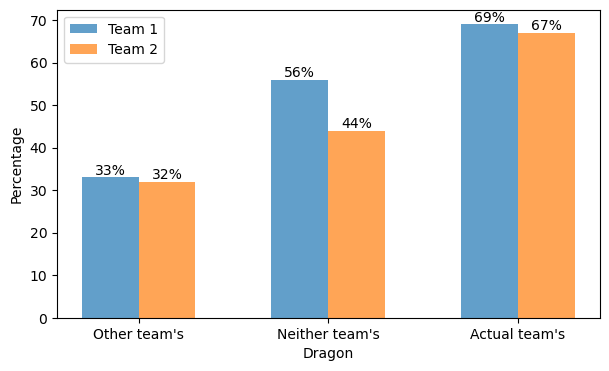

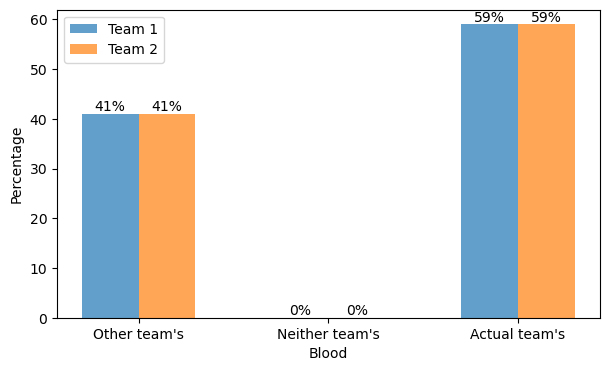

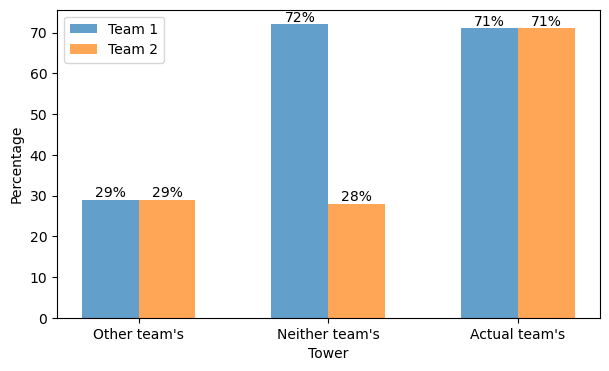

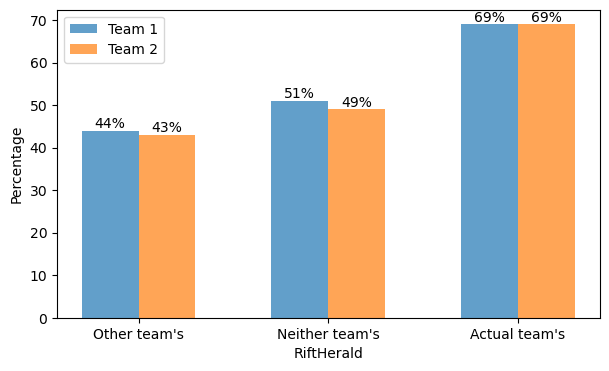

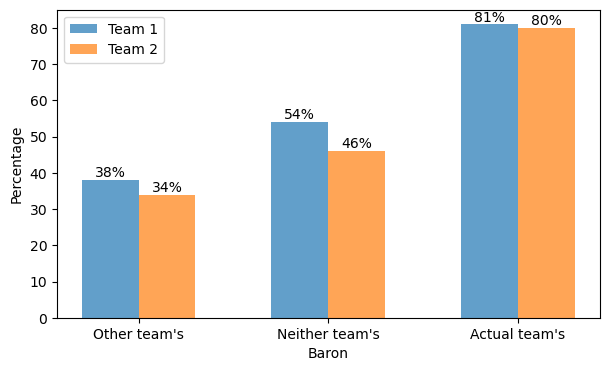

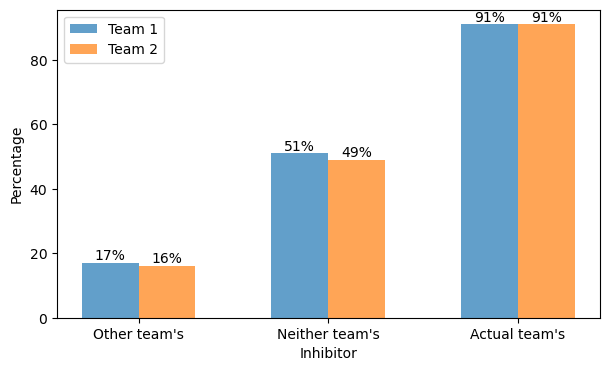

[None, None, None, None, None, None]

In [116]:
# Creating a single cell with every graph:

column_names = df_1stwr.columns
values = [name.split("first")[1].split(" (")[0] for name in column_names]
unique_values = list(set(values))
unique_values

[single_objective_analysis(obj) for obj in unique_values]

Putting it all in a single cell:

<Figure size 1700x800 with 0 Axes>

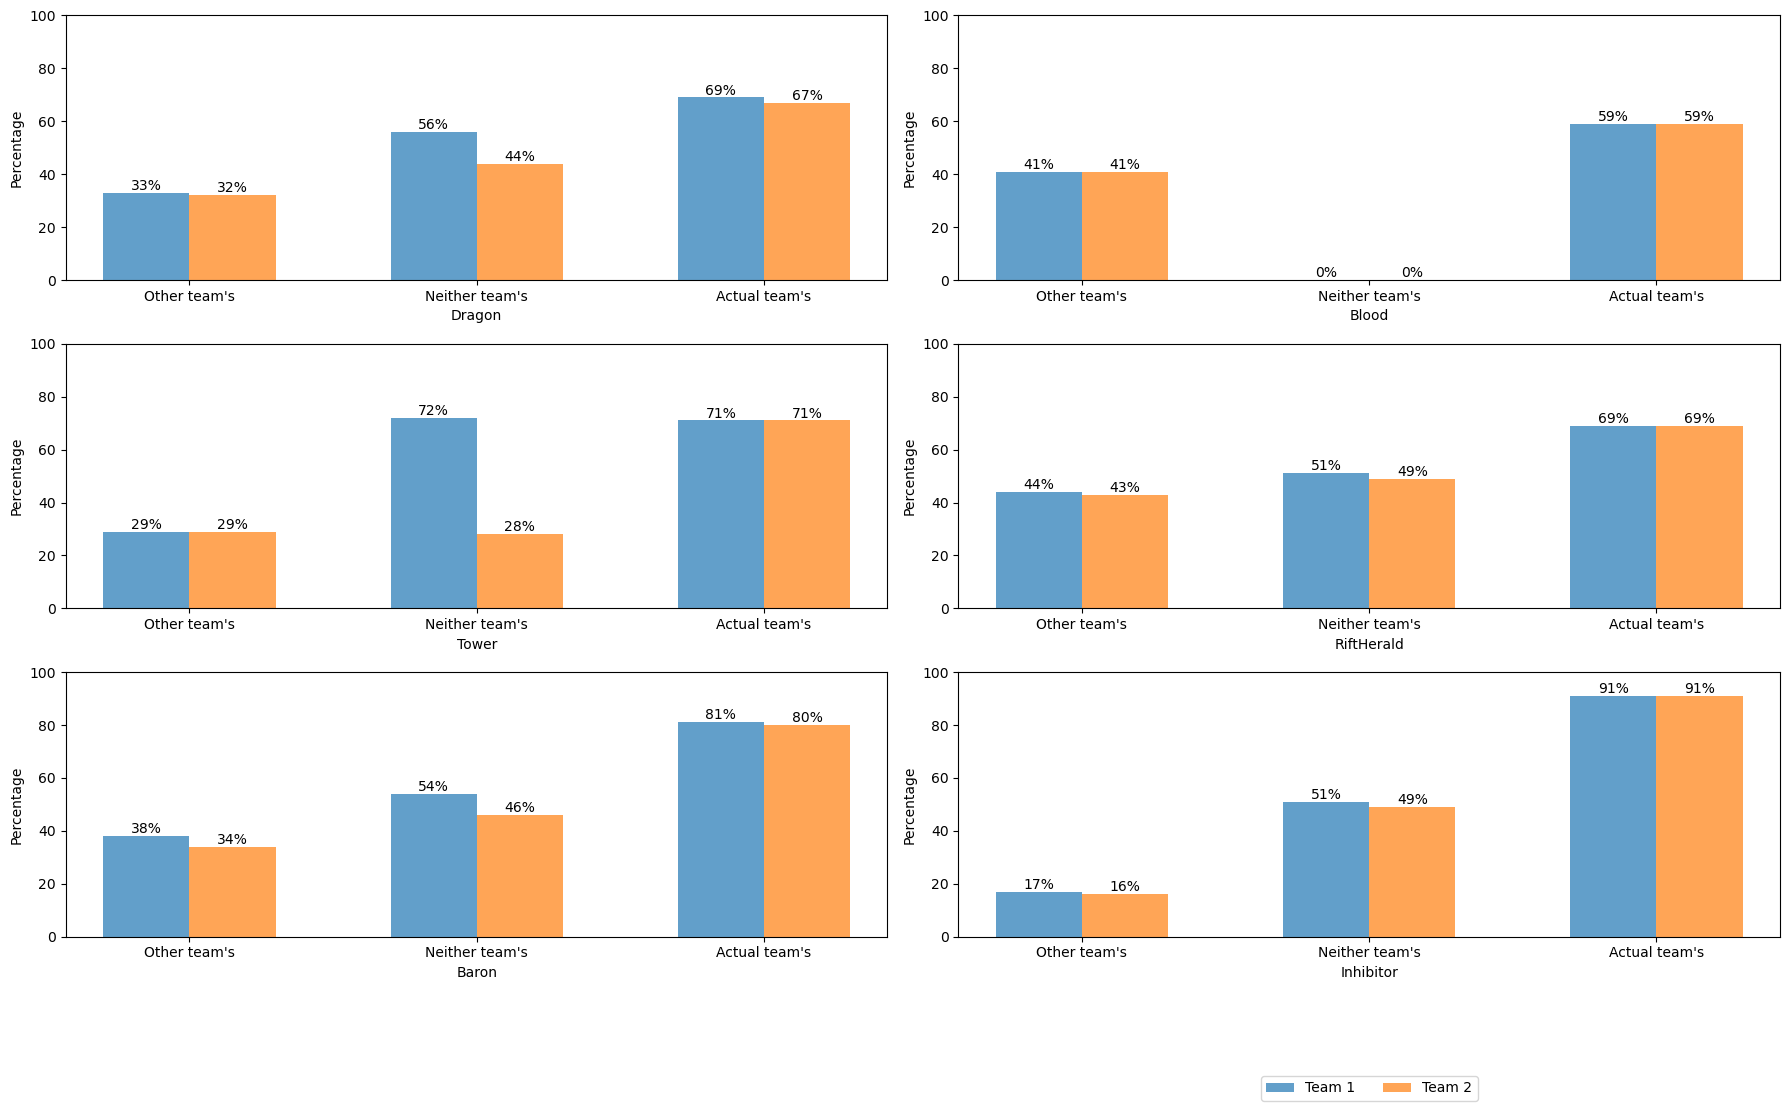

In [117]:
def objective_analysis(ax, objective):
    columns_chosen = [word for word in df_1stwr.columns if objective in word]
    
    df_graph = df_1stwr[columns_chosen]

    data = np.concatenate((df_graph.iloc[:3].values, df_graph.iloc[3:6].values), axis=0)

    labels = ["Other team's", "Neither team's", "Actual team's"]
    x = np.arange(len(labels))
    width = 0.3

    bars1 = ax.bar(x - width/2, data[0, :3], width, label='Team 1', alpha=0.7)
    bars2 = ax.bar(x + width/2, data[0, -3:], width, label='Team 2', alpha=0.7)
    
    ax.set_ylabel('Percentage')
    ax.set_xlabel(objective)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    # Add percentage labels on each bar
    for bar1, bar2 in zip(bars1, bars2):
        ax.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height(), f'{int(bar1.get_height())}%', ha='center', va='bottom')
        ax.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height(), f'{int(bar2.get_height())}%', ha='center', va='bottom')

    ax.set_ylim(top=100)
  

plt.figure(figsize=(17, 8))
# Create the subplot grid
num_plots = len(unique_values)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))

# Fill the subplots with the graphs
for i, objective in enumerate(unique_values):
    row = i // num_cols
    col = i % num_cols
    if num_rows == 1:
        ax = axes[col]
    else:
        ax = axes[row, col]
    objective_analysis(ax, objective)

# Adjust the layout of the subplots
plt.tight_layout()

# Move the legend outside the axes
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=2)

# Show the plot
plt.show()



OBS: Winning without taking towers/inhibs makes sense since it can be a forfeit

### Correlation between objectives, and objective vs winner (incomplete)
- Between first objectives and win
- Among first objectives
- Between objective kills and win

Remember:

    - First objectives: nominal
    - Win: dichotomous
    - Objective kills: nominal

In [118]:
!pip install termcolor

In [119]:
# Heatmap
import seaborn as sns
import pandas as pd
import numpy as np

# Exemplo de dados da tabela de contingência
data = {'var1': ['c1,1', 'c1,2', 'c1,3'],
        'var2': ['c2,1', 'c2,2', 'c2,3'],
        'var3': ['c3,1', 'c3,2', 'c3,3'],
        'var4': ['c4,1', 'c4,2', 'c4,3']}

df_2 = pd.DataFrame(data)

# Converter os valores para números
df_numeric = df.applymap(lambda x: ord(x[1]) - ord('0'))

# Plotando o heatmap
sns.heatmap(df_numeric, annot=True, cmap='coolwarm')

TypeError: 'int' object is not subscriptable

In [125]:
df_matrix = pd.DataFrame(columns=['winner'] + first_objectives,index=['winner'] + first_objectives)
df_matrix

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald
winner,NaN,NaN,NaN,NaN,NaN,NaN,NaN
firstBlood,NaN,NaN,NaN,NaN,NaN,NaN,NaN
firstTower,NaN,NaN,NaN,NaN,NaN,NaN,NaN
firstInhibitor,NaN,NaN,NaN,NaN,NaN,NaN,NaN
firstBaron,NaN,NaN,NaN,NaN,NaN,NaN,NaN
firstDragon,NaN,NaN,NaN,NaN,NaN,NaN,NaN
firstRiftHerald,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [236]:
from scipy.stats import chi2_contingency
# Getting columns:
kill_columns = [column for column in df.columns if 'Kills' in column]
first_objectives = [column for column in df.columns if 'first' in column]

df_corr = df[['winner']+kill_columns+first_objectives]


def chi2_analysis(variable1,variable2):
    contingency_table = pd.crosstab(variable1,variable2)
#     print('\n--- Chi2 analysis:',variable1.name, 'vs', variable2.name, ' ---\n')
#     print(contingency_table)
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.values.sum()
    contingency_coef = np.sqrt(chi2/(chi2+n))
#     print('Contingency coefficient: ',contingency_coef, '\n\n')
    
#     if ((contingency_coef>=0) & (contingency_coef < 0.2)):
#         print('-> Very Weak correlation!!')
#     elif ((contingency_coef>=0.2) & (contingency_coef < 0.4)):
#         print('-> Weak correlation!!')
#     elif ((contingency_coef>=0.4) & (contingency_coef < 0.6)):
#         print('-> Moderate correlation!!')
#     elif ((contingency_coef>=0.6) & (contingency_coef < 0.8)):
#         print('-> Strong correlation!!')
#     elif ((contingency_coef>=0.8) & (contingency_coef <= 1)):
#         print('-> Very strong correlation!!')
    return contingency_coef

#row = {first_objective: cor1, cor2, cor3, cor4, ....}
#df_matrix = pd.DataFrame(columns=first_objectives, index=first_objectives)
# result = []
# for first_objective in first_objectives:
#     result.append(chi2_analysis(df_corr['winner'], df_corr[first_objective]))
#     df_matrix.append({first_objective: result},ignore_index = True)

# #df_matrix = pd.DataFrame(df_matrix)
# df_matrix.append({first_objective: result},ignore_index = True)  
#print(df_matrix)
# for first_objective in first_objectives:
#     cramers_v(df_corr['winner'],df_corr[first_objective])

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

variables = ['winner'] + first_objectives
n_variables = len(variables)
df_matrix = np.zeros((n_variables, n_variables))

for i in range(n_variables):
    for j in range(n_variables):
        result = chi2_analysis(df_corr[variables[i]], df_corr[variables[j]])
        df_matrix[i, j] = result

category_bounds = [0, 0.2, 0.4, 0.6, 0.8, 1]
categories = ['Very Weak', 'Weak', 'Moderate', 'Strong', 'Very Strong']

# Create a DataFrame from the matrix
df_heatmap = pd.DataFrame(df_matrix, index=variables, columns=variables)

# Create a custom color map
colors = sns.color_palette('coolwarm', len(categories))
cmap = ListedColormap(colors)

# Adjust the figure size to avoid overlapping y-axis labels
fig, ax = plt.subplots(figsize=(10, 8))
# Definir os limites para cada categoria
category_bounds = [0, 0.2, 0.4, 0.6, 0.8, 1]
categories = ['Very Weak', 'Weak', 'Moderate', 'Strong', 'Very Strong']

# Criar uma lista de cores para cada categoria
colors = ['blue', 'cyan', 'white', 'orange', 'red']

# Criar uma lista de limites normalizados (0 a 1)
normalized_bounds = [(x - min(category_bounds)) / (max(category_bounds) - min(category_bounds)) for x in category_bounds]

# Criar uma lista de cores mapeadas para cada categoria
color_map = [colors[i] for i in range(len(categories))]

# Criar um colormap personalizado
cmap = ListedColormap(color_map)

# Plotar o heatmap
sns.heatmap(df_heatmap, annot=True, cmap=cmap, fmt=".2f", cbar=False, ax=ax, linecolor='white', vmin=0, vmax=1)

# Plot the heatmap
sns.heatmap(df_heatmap, annot=True, cmap=cmap, fmt=".2f", cbar=False, ax=ax, linecolor='white')

# Adjust the position of the lines indicating the edges of the rectangles
ax.hlines(np.arange(n_variables+1), *ax.get_xlim(), color='white', linewidth=1)
ax.vlines(np.arange(n_variables+1), *ax.get_ylim(), color='white', linewidth=1)

ax.set_xticks(np.arange(df_matrix.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(df_matrix.shape[0]) + 0.5, minor=False)

# Configure the tick labels
ax.set_xticklabels(df_heatmap.columns, rotation=45, ha="right")
ax.set_yticklabels(df_heatmap.index, rotation=0)

# Create a custom legend
legend_labels = [f'{category}: {category_bounds[i]:.1f} - {category_bounds[i+1]:.1f}' for i, category in enumerate(categories)]
legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=colors[i]) for i in range(len(categories))]

# Reverse the order of the legend elements and labels
legend_elements = legend_elements[::-1]
legend_labels = legend_labels[::-1]

# Add the legend
ax.legend(handles=legend_elements, labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the spacing to avoid overlapping y-axis labels
plt.subplots_adjust(left=0.25, top=0.95)

plt.show()



<Figure size 640x480 with 0 Axes>

In [235]:
# Definir os limites para cada categoria
category_bounds = [0, 0.2, 0.4, 0.6, 0.8, 1]
categories = ['Very Weak', 'Weak', 'Moderate', 'Strong', 'Very Strong']

# Criar uma lista de cores para cada categoria
colors = ['blue', 'cyan', 'white', 'orange', 'red']

# Criar uma lista de limites normalizados (0 a 1)
normalized_bounds = [(x - min(category_bounds)) / (max(category_bounds) - min(category_bounds)) for x in category_bounds]

# Criar uma lista de cores mapeadas para cada categoria
color_map = [colors[i] for i in range(len(categories))]

# Criar um colormap personalizado
cmap = ListedColormap(color_map)

# Plotar o heatmap
sns.heatmap(df_heatmap, annot=True, cmap=cmap, fmt=".2f", cbar=False, ax=ax, linecolor='white', vmin=0, vmax=1)


<AxesSubplot:>

In [ ]:
ax.set_title('Contigency coefficient analysis for each nominal variable')

In [157]:
variables = ['winner']+ first_objectives


7

In [148]:
!pip install researchpy

In [150]:
import researchpy as rp

cramer_matrix = rp.crosstab(df_corr['winner'], df_corr[first_objectives])
sns.heatmap(cramer_matrix, annot=True, cmap='coolwarm')

ValueError: Must pass 2-d input. shape=()

In [144]:
df_matrix

,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald
0,0.176832,NaN,NaN,NaN,NaN,NaN
1,NaN,0.383287,NaN,NaN,NaN,NaN
2,NaN,NaN,0.614492,NaN,NaN,NaN
3,NaN,NaN,NaN,0.43709,NaN,NaN
4,NaN,NaN,NaN,NaN,0.336756,NaN
5,NaN,NaN,NaN,NaN,NaN,0.266172


Results are reasonable, we would expect firstInhib to the winner beeing strongly related to firstInhib. To be fair, i would expect a more strong relationship between them. Let's try to build a more visual graph

In [ ]:
df_corr[first_objectives[0]].name

In [ ]:
for first_objective_1 in first_objectives:
    for first_objective_2 in first_objectives:
        if first_objective_1 == first_objective_2:
            continue
        else:
            chi2_analysis(df_corr[first_objective_1],df_corr[first_objective_2])


In [ ]:
pd.crosstab(df_corr)

In [ ]:
df.columns

In [ ]:
# First step is to transform them in binary

df_binary = pd.DataFrame(columns=['fb', 'ft'])


df_binary['fb'] = pd.concat

# winner_fb = pd.concat([df[df['winner'] == 1]['t1_towerKills'],df[df['winner'] == 2]['t2_towerKills']])

# loser_ft = pd.concat([df[df['winner'] == 1]['t2_towerKills'],df[df['winner'] == 2]['t1_towerKills']])



df_binary = df[['firstTower','firstBlood']].replace({1:1,2:0})


from sklearn.metrics import matthews_corrcoef

# Calcular a correlação de Matthews
correlation = matthews_corrcoef(df_binary['firstTower'], df_binary['firstBlood'])




print(correlation)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Example data - replace with your own data
data = df[['winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald']]

# Calculating the chi-square statistic for each pair of variables
num_vars = data.shape[1]
chi2_matrix = np.zeros((num_vars, num_vars))

for i in range(num_vars):
    for j in range(num_vars):
        contingency_table = pd.crosstab(data.iloc[:, i], data.iloc[:, j])
        chi2, _, _, _ = chi2_contingency(contingency_table)
        chi2_matrix[i, j] = chi2

# Creating the heatmap using seaborn
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = sns.heatmap(chi2_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=ax)

# Set the colorbar limits
#heatmap.collections[0].colorbar.set_clim(0, 10000)


plt.show()


In [ ]:
# Create a matrix of: winner, firstBlood, firstTower, firstInhib, firstBaron, firstDragon, firstHerald

In [ ]:
data

In [ ]:
winner_towers = pd.concat([df[df['winner'] == 1]['t1_towerKills'],df[df['winner'] == 2]['t2_towerKills']])

loser_towers = pd.concat([df[df['winner'] == 1]['t2_towerKills'],df[df['winner'] == 2]['t1_towerKills']])


winner_towers = winner_towers.to_frame()

winner_towers['winner'] = 1
loser_towers = loser_towers.to_frame()
loser_towers['winner'] = 0
teste = pd.concat([winner_towers,loser_towers])


correlation = np.corrcoef(teste[0], teste['winner'])[0, 1]

print(correlation)

### Starting to model: 
1) Predict the team winner with every piece of information we have on our disposal



2) It would be fun (especially for gamblers) to predict the winner with the minimal information available. I will do it using only team picks, bans, first blood, and first tower, as these pieces of information can be seen beforehand.

Removing irrelevant columns and getting target array. Features will be generated later

In [ ]:
# df_model represents the previous df right after removing the remaked matches
sum_columns = [columns for columns in df.columns if 'sum' in columns]
target = df['winner']
df_model.drop(['gameId','creationTime','seasonId','winner']+bans_t1+bans_t2,axis=1, inplace=True)

I personally dont like the following approach, since different pick orders will be interpreted differently, but im curious to get the difference between a model with this problem and without it (for now i thought about sorting the picks)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


def model_and_results(features,target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    model = RandomForestClassifier()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    print("Matriz de Confusão:")
    #conf_matrix = confusion_matrix(y_test, y_pred)
    print(confusion_matrix(y_test, y_pred))


    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)


    precision = precision_score(y_test, y_pred)
    print("Precision:", precision)


    recall = recall_score(y_test, y_pred)
    print("Recall:", recall)


    f1 = f1_score(y_test, y_pred)
    print("F1-Score:", f1)
    
    importances = model.feature_importances_

    # Criar um DataFrame para visualizar as importâncias
    importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': importances})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Imprimir as importâncias das variáveis
    print('\n\n',importance_df)


In [ ]:
print('With every bit of information:')
features = df_model

model_and_results(features,target)

In [ ]:
# Removing ammount of kills to be less specific

features = df_model.drop(kill_columns, axis=1)

model_and_results(features,target)

Results are incredible! But let's dig a little more. I want to sort the picks to check if it's relevant algorithm-wise:

In [ ]:
df_model['comp_1'] = df_model[champs_t1].apply(sorted, axis=1)
df_model['comp_2'] = df_model[champs_t2].apply(sorted, axis=1)
split_1 = pd.DataFrame(df_model['comp_1'].to_list(), columns = champs_t1)
split_2 = pd.DataFrame(df_model['comp_2'].to_list(), columns = champs_t2)
split_sorted = pd.concat([split_1,split_2],axis=1)
#df_model
sorted_features = pd.concat([df_model.drop(['comp_1','comp_2']+champs_t1+champs_t2,axis=1).reset_index(drop=True),split_sorted],axis=1)
sorted_features

In [ ]:
print('Now with picks in order')

model_and_results(sorted_features.drop(kill_columns,axis=1),target)

It was a little bit better, so that concludes that we should rearrange our data accordingly

In [ ]:
print('Picks with first main objectives')
model_and_results(sorted_features[champs_t1+champs_t2+first_objectives],target)

It was impressive how first objectives are so relevant to the game wins. But, for a gambler stand point, let's suppose we choose to gamble after we see the first blood, tower and dragon:

In [ ]:
print('Picks with early objectives')
model_and_results(sorted_features[['firstBlood','firstTower','firstDragon']+champs_t1+champs_t2],target)

Thats a pretty decent result. With only picks, first blood and first tower, we have 71% accuracy to predict the winner. Let me check if summoners are relevant

In [ ]:
model_and_results(sorted_features[['firstBlood','firstTower','firstDragon']+champs_t1+champs_t2+sum_columns],target)

It was actually a relevant improvement